In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

pd.options.mode.chained_assignment = None

def Split_Contigs_ID(s, options):
    splits = s.split('_')
    if options == 'S':
        return splits[0]
    else:
        return "_".join(splits[1:])


In [117]:
df = pd.read_csv('../../Mount/Phage_Discovery_Project/Phage_Candidates_Genes_New.txt',
                 names = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 
                          'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 
                          'bitscore', 'qlen', 'slen'], sep = '\t')
df_cluster = pd.read_csv('../../Mount/Potential_Phages_Updated/Clustering_Results.csv')
df_uniprot_metadata = pd.read_csv( '/Users/harihara/Research-Activities/Data/Uniprot_Meta_Data.csv')
df['pident'] = (df['length']-df['mismatch'])/df['slen']*100
del df_uniprot_metadata['Integrase']

In [118]:
df_uniprot_hits = df[df['pident']>=50.75]
print(len(df_uniprot_hits))
df_uniprot_hits['SampleID'] = df_uniprot_hits['qseqid'].apply(partial(Split_Contigs_ID, options = 'S'))
df_uniprot_hits['ContigID'] = df_uniprot_hits['qseqid'].apply(partial(Split_Contigs_ID, options = 'C'))
df_uniprot_hits = df_uniprot_hits.set_index(['SampleID','ContigID'])
df_uniprot_hits = df_uniprot_hits[['sseqid', 'qseqid', 'length', 'qlen']]

df_cluster['SampleID'] = df_cluster['Contigs'].apply(partial(Split_Contigs_ID, options = 'S'))
df_cluster['ContigID'] = df_cluster['Contigs'].apply(partial(Split_Contigs_ID, options = 'C'))
df_cluster = df_cluster[['SampleID','ContigID','Contigs','Complete_0.61']]
df_cluster_groups = df_cluster.groupby('Complete_0.61').nunique().rename(
    columns = {'SampleID':'Samples(Cluster)','Contigs':'#Contigs(Cluster)'})
del df_cluster_groups['Complete_0.61'], df_cluster_groups['ContigID']
df_cluster_groups = df_cluster_groups.reset_index()

df_cluster = df_cluster.set_index(['SampleID','ContigID'])
df_uniprot_hits = df_uniprot_hits.join(df_cluster, how = 'left')
del df_uniprot_hits['Contigs']
df_uniprot_hits = df_uniprot_hits.reset_index()

df_uniprot_cluster_counts = df_uniprot_hits[['SampleID','qseqid','Complete_0.61']].groupby(
    'Complete_0.61').nunique()
del df_uniprot_cluster_counts['Complete_0.61']
df_uniprot_cluster_counts = df_uniprot_cluster_counts.rename(columns = {'SampleID':'#Samples(Phages)', 
                                                            'qseqid':'#Contigs(Phages)'}).reset_index()
df_uniprot_hits = pd.merge(df_uniprot_hits, df_cluster_groups, how = 'left', on = ['Complete_0.61'])
df_uniprot_hits = pd.merge(df_uniprot_hits, df_uniprot_cluster_counts, how = 'left', on = ['Complete_0.61'])
df_uniprot_hits = pd.merge(df_uniprot_hits, df_uniprot_metadata, left_on = ['sseqid'], 
                           right_on = ['Phage_ID'], how = 'left')

#df_uniprot_hits.to_csv('Cluster_Analysis_Phages.csv')

6806


In [120]:
df_sample_cluster_analysis = df_uniprot_cluster_counts[['#Samples(Phages)']]
df_sample_cluster_analysis = df_sample_cluster_analysis[df_sample_cluster_analysis['#Samples(Phages)'] > 4]
df_sample_cluster_analysis['#Samples(Phages)'] = np.ceil(df_sample_cluster_analysis['#Samples(Phages)']/5)*5
df_sample_cluster_analysis['Counts'] = 1
df_sample_cluster_analysis = df_sample_cluster_analysis.groupby('#Samples(Phages)').sum()
df_sample_cluster_analysis.index = df_sample_cluster_analysis.index.astype(int)

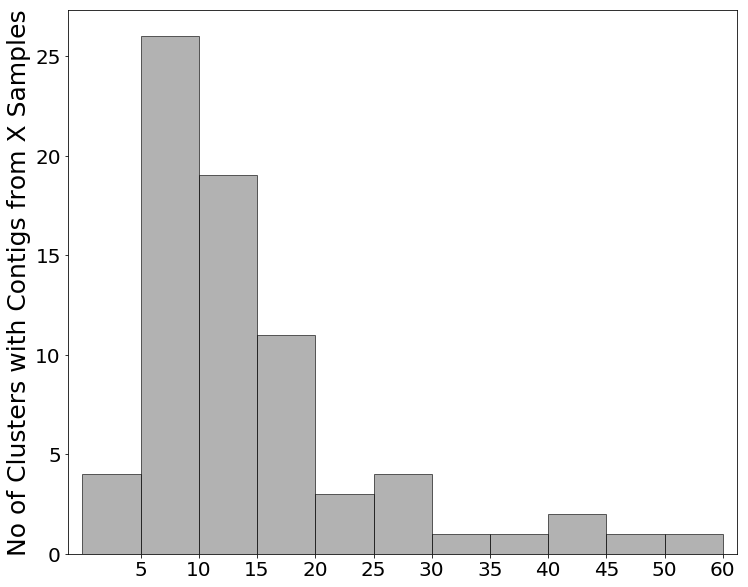

In [121]:
ax = df_sample_cluster_analysis.plot(kind = 'bar', color = 'gray', alpha = 0.6, legend = False, 
                                     figsize = (12,10), width = 1, edgecolor = 'black')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('No of Clusters with Contigs from X Samples', fontsize = 25)
ax.set_xlabel('')
fig = ax.get_figure()
x = np.arange(len(df_sample_cluster_analysis)) + 0.5
plt.xticks(x, df_sample_cluster_analysis.index, rotation = 0)
fig.tight_layout()
fig.savefig('Sample-Specific-vs-Prevelant-Clusters.pdf')

In [157]:
cluster_50 = df_uniprot_hits[df_uniprot_hits['Complete_0.61']==23]
contigs = cluster_50['qseqid'].unique()
gene_ids = []
genes_counter = dict()
for contig in contigs:
    genes = list(cluster_50[cluster_50['qseqid']==contig]['sseqid'])
    genes.sort()
    gene_ids.append(genes)
    for gene in genes:
        try:
            genes_counter[gene] += 1
        except KeyError:
            genes_counter[gene] = 1

In [158]:
df_genes_50 = pd.DataFrame(data = {'Contigs':contigs, 'Genes':gene_ids})

In [159]:
df_genes_50 = df_genes_50.sort_values(by = 'Contigs')

In [160]:
df_genes_counter = pd.DataFrame()
df_genes_counter['Genes'] = genes_counter.keys()
df_genes_counter['Counter'] = genes_counter.values()
df_genes_counter.sort_values(by = ['Counter'], ascending = False, inplace = True)
df_genes_counter = pd.merge(df_genes_counter, df_uniprot_metadata, left_on= ['Genes'],
                            right_on = ['Phage_ID'], how ='left')
del df_genes_counter['Phage_ID'], df_genes_counter['Organism Name']

In [161]:
df_genes_counter_grouped = df_genes_counter.groupby('Protein Identifier').sum()
df_genes_counter_grouped = df_genes_counter_grouped.rename(columns = 
                                                           {'Counter':'Number of contigs containing the Protein'})

In [162]:
df_genes_counter_grouped.sort_values(by = 'Number of contigs containing the Protein', ascending = False).head(10)

,Number of contigs containing the Protein
Protein Identifier,
Integrase,318
Site-specific recombinase,74
Integrase/recombinase,60
Uncharacterized protein,44
Site-specific integrase,36
Putative integrase,26
Site-specific recombinase integrase family protein,21
Integrase domain protein,9
DNA integration/recombination/inversion protein,8
